In [1]:
'''REQUIRED LIBRARIES'''
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import math


import plotly.graph_objs as go


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, UpSampling2D, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


2024-03-28 15:54:03.018777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 15:54:03.018865: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 15:54:03.027282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 15:54:03.078780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 15:54:04.491338: W tensorflow/compiler/tf2

## Check active GPU 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-03-28 15:54:11.118172: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:11.335862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:11.335928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## MAIN MODEL FOR GREYSCALE IMAGES

### Load Data

In [3]:
#Set the path to the folder containing the image as required

train_path_4 = '..//raw_data/archive/all_train'

In [4]:
def paginate_folder(dir_path, page_no, page_size):
    '''
    Goes though folder and returns lists of the containing filenames in pages
    dirpath: folder location 
    page_size: how many files to include in a page
    page_no: which page to return
    '''
    
    all_file_names = os.listdir(dir_path)
    all_file_names.sort()
    
    
    # page 1, page size 5000 -> first file index 0
    # page 2, page size 5000 -> first file index 2000
    first_file_in_page_index = (page_no - 1) * page_size
    
    page = all_file_names[first_file_in_page_index : first_file_in_page_index + page_size]
    
    x =[]
    for filename in page:
        x.append(os.path.join(dir_path, filename))
    
    return x
    
    

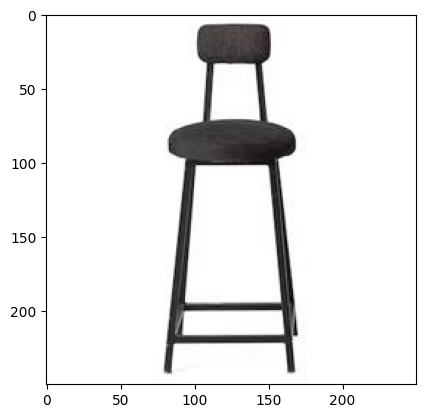

In [5]:
#testing paginate_folder
page = paginate_folder(train_path_4,1,10)

plt.imshow(mpimg.imread(page[0]),cmap='gray')
plt.show();

In [6]:
mpimg.imread(page[0]).shape

(250, 250, 3)

In [7]:
def page_numbers(dir_path, page_size):
    '''determine how many pages required for specific folder 
    based on how many files included in each file
    '''
    all_file_names = os.listdir(dir_path)
    return math.ceil( len(all_file_names)/page_size)

In [8]:

page_num = page_numbers(train_path_4,10)

In [9]:
# Declare page size - will be applied 
page_size =1000

In [10]:
# Show pages with their size
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages+1):
    page_filenames =paginate_folder(train_path_4,page_num, page_size)
    print(f'page {page_num}, files found: {len(page_filenames)}')
    

page 1, files found: 1000
page 2, files found: 1000
page 3, files found: 1000
page 4, files found: 1000
page 5, files found: 1000
page 6, files found: 1000
page 7, files found: 1000
page 8, files found: 45


In [11]:
def filepath_to_preprocessed_array(filepath): 
    '''
    takes image filepath and returns preprocessed array
    preprocessing includes: 
    -resizing to 100x100
    -converting to greyscale
    -normalizing
    '''
    
    # Check if the file is an image
    if filepath.endswith((".jpg", ".png")):
        # Load the image
        img = Image.open(filepath)
        
        # Convert image to RGBA mode if not already
        if img.mode != 'RGBA':
            img = img.convert('RGBA')

        # Create a white background image of the same size
        white_bg = Image.new('RGBA', img.size, (255, 255, 255, 255))

        # Composite the original image over the white background
        result = Image.alpha_composite(white_bg, img)

        # Resize the image to (100, 100)
        result = result.resize((100, 100)).convert('L')

        # Convert the result to numpy array
        result = np.array(result)

        # Normalize pixel values to range [0, 1]
        result = result / 255.0

        # Return preprocessed image array
        return result
    else:
        print("File format not supported. Please provide a .jpg or .png file.")

In [12]:
#quick ckeck 
filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/folder_b/image2.png').shape

(100, 100)

In [13]:

def filepaths_to_preprocessed_arrays(filepaths):
    '''
    returns an array containing images as arrays
    '''
    result = []
    for f in filepaths:
        result.append(filepath_to_preprocessed_array(f))
    return np.array(result)


### Building the Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense, ZeroPadding2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(12 * 12 * 128, activation='relu')(input_encoded)  # Calculate the number of neurons to match the desired shape
    x = Reshape((12, 12, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    x = ZeroPadding2D(2)(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (100, 100, 1)
encoding_dim = 200  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')

2024-03-28 15:54:54.315263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:54.315405: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:54.315438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:54.658023: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 15:54:54.658100: I external/local_xla/xla/stream_executor

[(None, 200), (None, 200), (None, 200)]


### Train the model

In [16]:
page_size = 2000
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages+1):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    
    print (f'fitting page number {page_num} out of {num_pages}')
    autoencoder_vae.fit(training_page,training_page, epochs=20, batch_size=32, shuffle=True)

fitting page number 1 out of 4
Epoch 1/20
63/63 [==============================] - 3s 47ms/step - loss: 4907.5356
Epoch 2/20
63/63 [==============================] - 2s 27ms/step - loss: 4460.8613
Epoch 3/20
63/63 [==============================] - 2s 26ms/step - loss: 4245.9536
Epoch 4/20
63/63 [==============================] - 2s 26ms/step - loss: 4152.1743
Epoch 5/20
63/63 [==============================] - 2s 27ms/step - loss: 4079.5586
Epoch 6/20
63/63 [==============================] - 2s 27ms/step - loss: 4029.8198
Epoch 7/20
63/63 [==============================] - 2s 27ms/step - loss: 3985.1238
Epoch 8/20
63/63 [==============================] - 2s 27ms/step - loss: 3930.9299
Epoch 9/20
63/63 [==============================] - 2s 26ms/step - loss: 3908.0352
Epoch 10/20
63/63 [==============================] - 2s 26ms/step - loss: 3871.4490
Epoch 11/20
63/63 [==============================] - 2s 26ms/step - loss: 3852.9905
Epoch 12/20
63/63 [==============================] - 2

### Visualize results

#### Show input images next to their reconstructed outputs

In [17]:

def plot_reconstructions(model, images, n_images=5):
    '''
    function that iputs images passes them though an autoencoder model and plots them next to the reconstructed images
    '''
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="gray")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="gray")
        plt.axis("off")


working on page number 1
1/1 [==============================] - 1s 824ms/step
working on page number 2
1/1 [==============================] - 0s 17ms/step


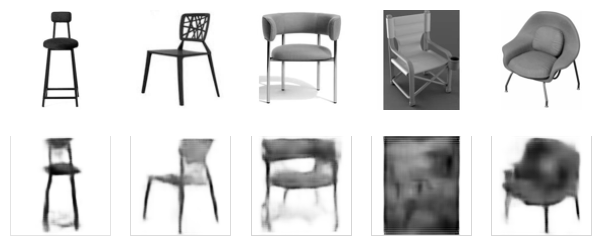

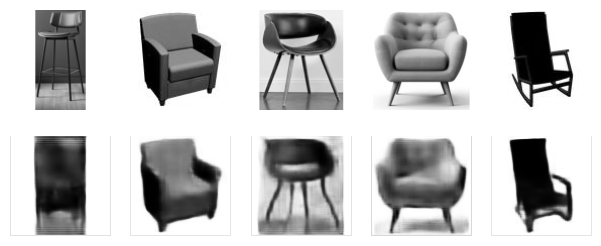

In [18]:
### pass 5 images from the first two pages for testing
for page_num in range(1, 3):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    print (f'working on page number {page_num}')
    
    plot_reconstructions(autoencoder_vae,training_page,5)

#### Create random outputs

In [19]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="gray")
        plt.axis("off")

In [20]:
#create 21 random vector of the latent size and use the decoder to reconstruct images
codings = tf.random.normal(shape=[3 * 7, 200]) # for latent size =100
random_images_vae = decoder_vae(codings).numpy()

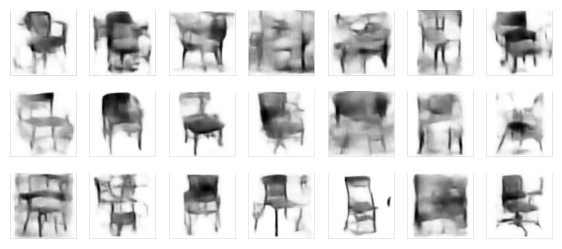

In [21]:
plot_multiple_images(random_images_vae, 7)
plt.show()

#### Interpolate between images

In [ ]:
for page_num in range(1, 2):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays(page_filenames)
    print (type(training_page))
    
    image1 = training_page[0]  # Input image 1 - Replace with actual indices
    image2 = training_page[610]  # Input image 2-  Replace with actual indices
    print(type(image1))
    print(image1.shape)


    # Encode the images
    _, _, encoding1 = encoder_vae.predict(np.array([image1]))
    _, _, encoding2 = encoder_vae.predict(np.array([image2]))


1/1 [==============================] - 0s 16ms/step


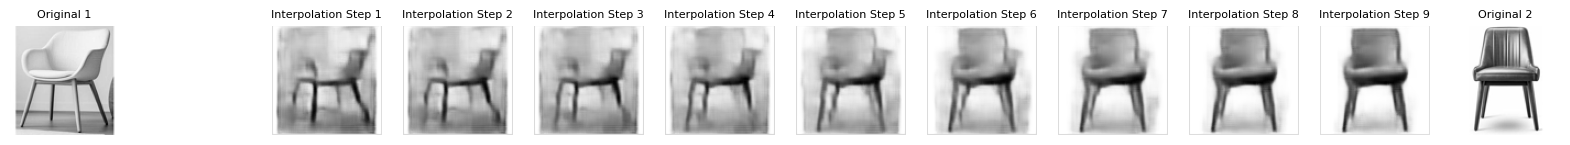

In [23]:
# Interpolate between the encodings
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 200))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


#### Interpolate between images that the model hasn't seen before

In [24]:
img1 = filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/test/image124.jpg')
img2 = filepath_to_preprocessed_array('..//raw_data/archive/rendered_chairs/test/image241.jpg')

In [25]:
type(img1)

numpy.ndarray

In [26]:
_,_,encoding1 =encoder_vae.predict(np.array([img1]))
_,_,encoding2 =encoder_vae.predict(np.array([img2]))

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


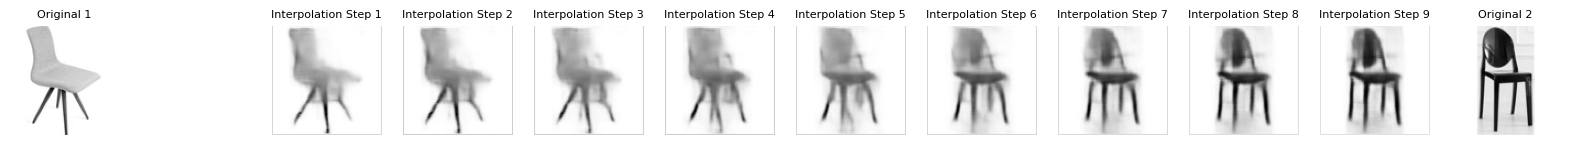

In [27]:
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 200))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(img2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(img1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


-----------------------------------

## MODEL FOR COLOUR IMAGES

In [28]:

def sampling(args):
    '''Reparametrization trick z-mu +sigma +epsilon'''
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def build_encoder_vae(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    flattened = Flatten()(x)
    z_mean = Dense(encoding_dim, name='z_mean')(flattened)
    z_log_var = Dense(encoding_dim, name='z_log_var')(flattened)
    z = Lambda(sampling, output_shape=(encoding_dim,), name='z')([z_mean, z_log_var])
    return Model(input_img, [z_mean, z_log_var, z])

def build_decoder_vae(encoded_dim, input_shape):
    input_encoded = Input(shape=(encoded_dim,))
    x = Dense(12 * 12 * 128, activation='relu')(input_encoded)  # Calculate the number of neurons to match the desired shape
    x = Reshape((12, 12, 128))(x)  # Reshape to match the shape after the last pooling layer in the encoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Change padding to 'same'
    x = UpSampling2D((2, 2))(x)
    x = ZeroPadding2D(2)(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Change padding to 'same'
    return Model(input_encoded, decoded)

# Define input shape and encoding dimension
input_shape = (100, 100, 3)  # Adjusted for colored images
encoding_dim = 100  # Example encoding dimension

# Build encoder and decoder
encoder_vae = build_encoder_vae(input_shape, encoding_dim)
print(encoder_vae.output_shape)

decoder_vae = build_decoder_vae(encoding_dim, input_shape)

# Combine encoder and decoder into autoencoder
input_img = Input(shape=input_shape)
z_mean, z_log_var, z = encoder_vae(input_img)
decoded = decoder_vae(z)
autoencoder_vae = Model(input_img, decoded)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(decoded))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]  # Adjusted for colored images
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
autoencoder_vae.add_loss(vae_loss)

# Compile the VAE
autoencoder_vae.compile(optimizer='adam')


[(None, 100), (None, 100), (None, 100)]


In [29]:
def filepath_to_preprocessed_array_colour(filepath): 

    # Check if the file is an image
    if filepath.endswith(".jpg") or filepath.endswith(".png"):
        # Load the image
        img = Image.open(filepath)
        
        img = img.convert('RGB')

        
        
        result = img.resize((100,100))
        
        result = np.array(result)
        result = result/255.0
        
        # Check if the output array is empty
        if np.all(result == 0):
            print(f"Empty array generated for image: {filepath}")
        # return image
        return result

In [30]:
filepath_to_preprocessed_array_colour('..//raw_data/archive/processed_images_colour_256x256/1.jpg').shape

(100, 100, 3)

In [31]:
def filepaths_to_preprocessed_arrays_colour(filepaths):
    result = []
    for f in filepaths:
        result.append(filepath_to_preprocessed_array_colour(f))
    return np.array(result)

In [57]:
page_size=2000
num_pages = page_numbers(train_path_4, page_size)
for page_num in range(1, num_pages+1):
    #print(f'page_num {page_num}')
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    #print(f'page_filenames {page_filenames}')
    training_page = filepaths_to_preprocessed_arrays_colour(page_filenames)
    
    print (f'fitting page number {page_num} out of {num_pages}')
    autoencoder_vae.fit(training_page,training_page, epochs=30, batch_size=8, shuffle=True)

fitting page number 1 out of 4
Epoch 1/50
250/250 [==============================] - 3s 12ms/step - loss: 10317.3408
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 10100.1445
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 10015.9248
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 9970.1641
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 9936.4736
Epoch 6/50
250/250 [==============================] - 3s 12ms/step - loss: 9910.4121
Epoch 7/50
250/250 [==============================] - 3s 12ms/step - loss: 9907.2871
Epoch 8/50
250/250 [==============================] - 3s 12ms/step - loss: 9885.6963
Epoch 9/50
250/250 [==============================] - 3s 12ms/step - loss: 9867.6201
Epoch 10/50
250/250 [==============================] - 3s 11ms/step - loss: 9856.6182
Epoch 11/50
250/250 [==============================] - 3s 12ms/step - loss: 9844.4785
Epoch 12/50
250/250 [========

250/250 [==============================] - 3s 13ms/step - loss: 9619.7607
Epoch 46/50
250/250 [==============================] - 3s 13ms/step - loss: 9622.1885
Epoch 47/50
250/250 [==============================] - 3s 14ms/step - loss: 9612.8887
Epoch 48/50
250/250 [==============================] - 3s 12ms/step - loss: 9607.9658
Epoch 49/50
250/250 [==============================] - 3s 13ms/step - loss: 9618.3301
Epoch 50/50
250/250 [==============================] - 3s 13ms/step - loss: 9630.2617
fitting page number 3 out of 4
Epoch 1/50
250/250 [==============================] - 3s 14ms/step - loss: 9804.3408
Epoch 2/50
250/250 [==============================] - 3s 13ms/step - loss: 9624.4131
Epoch 3/50
250/250 [==============================] - 3s 13ms/step - loss: 9521.1406
Epoch 4/50
250/250 [==============================] - 3s 12ms/step - loss: 9468.6338
Epoch 5/50
250/250 [==============================] - 3s 12ms/step - loss: 9424.5361
Epoch 6/50
250/250 [====================

131/131 [==============================] - 2s 15ms/step - loss: 6061.7900
Epoch 40/50
131/131 [==============================] - 2s 15ms/step - loss: 6054.1470
Epoch 41/50
131/131 [==============================] - 2s 14ms/step - loss: 6045.3623
Epoch 42/50
131/131 [==============================] - 2s 14ms/step - loss: 6037.8896
Epoch 43/50
131/131 [==============================] - 2s 15ms/step - loss: 6058.4233
Epoch 44/50
131/131 [==============================] - 2s 14ms/step - loss: 6038.1655
Epoch 45/50
131/131 [==============================] - 2s 14ms/step - loss: 6033.7041
Epoch 46/50
131/131 [==============================] - 2s 14ms/step - loss: 6033.5635
Epoch 47/50
131/131 [==============================] - 2s 14ms/step - loss: 6036.2266
Epoch 48/50
131/131 [==============================] - 2s 14ms/step - loss: 6037.3159
Epoch 49/50
131/131 [==============================] - 2s 15ms/step - loss: 6022.9360
Epoch 50/50
131/131 [==============================] - 2s 15ms/ste

In [58]:
#create 21 random vector of the latent size and use the decoder to reconstruct images
codings = tf.random.normal(shape=[3 * 7, 100]) # for latent size =100
random_images_vae = decoder_vae(codings).numpy()

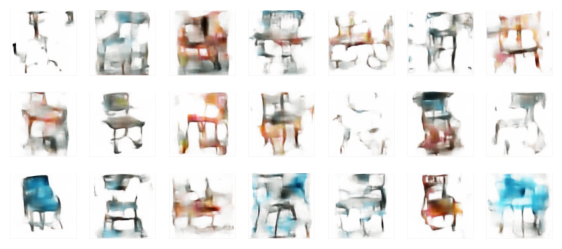

In [59]:
plot_multiple_images(random_images_vae, 7)
plt.show()

working on page number 1
1/1 [==============================] - 0s 24ms/step
working on page number 2
1/1 [==============================] - 0s 25ms/step


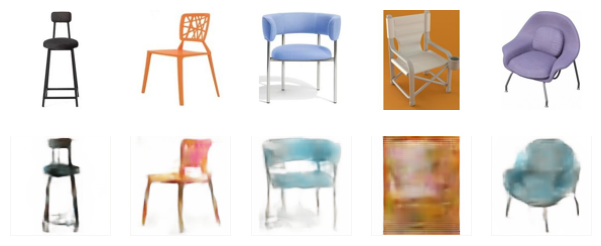

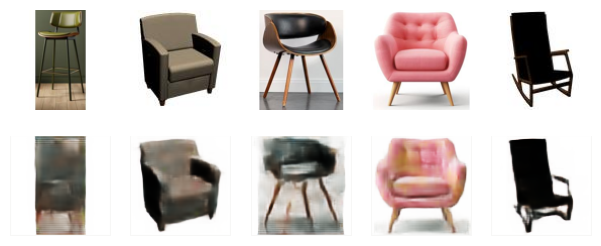

In [60]:
### pass 5 images from the first two pages for testing
for page_num in range(1, 3):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays_colour(page_filenames)
    print (f'working on page number {page_num}')
    
    plot_reconstructions(autoencoder_vae,training_page,5)

In [61]:
for page_num in range(1, 2):
    page_filenames = paginate_folder(train_path_4,page_num, page_size)
    training_page = filepaths_to_preprocessed_arrays_colour(page_filenames)
    print (type(training_page))
    
    image1 = training_page[2]  # Input image 1 - Replace with actual indices
    image2 = training_page[1]  # Input image 2-  Replace with actual indices
    print(type(image1))
    print(image1.shape)


    # Encode the images
    _, _, encoding1 = encoder_vae.predict(np.array([image1]))
    _, _, encoding2 = encoder_vae.predict(np.array([image2]))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(100, 100, 3)
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


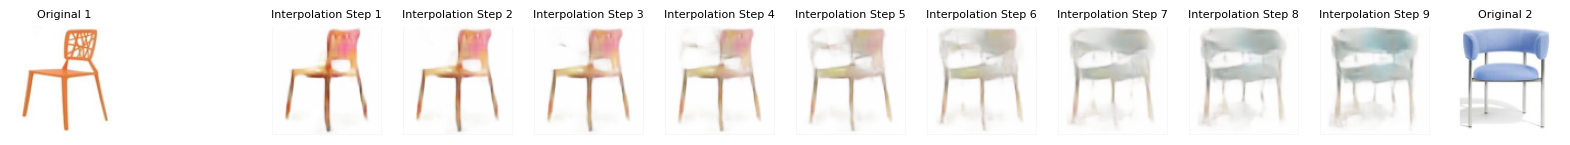

In [62]:
# Interpolate between the encodings
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 100))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(image2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(image1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


In [53]:
img1 = filepath_to_preprocessed_array_colour('..//raw_data/archive/testing/3719c8a67a5a846fcda4086b9fe1d09-image_060_p030_t325_r096.png')
img2 = filepath_to_preprocessed_array_colour('..//raw_data/archive/testing/1a8a5008e09f8f2363ed57e35c972b4b-image_027_p020_t313_r096.png')

In [54]:
f0ed4a88-efa0-48c7-b0fe-7509fa897d7f_100x100

SyntaxError: invalid decimal literal (1821259819.py, line 1)

In [55]:
_,_,encoding1 =encoder_vae.predict(np.array([img1]))
_,_,encoding2 =encoder_vae.predict(np.array([img2]))

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


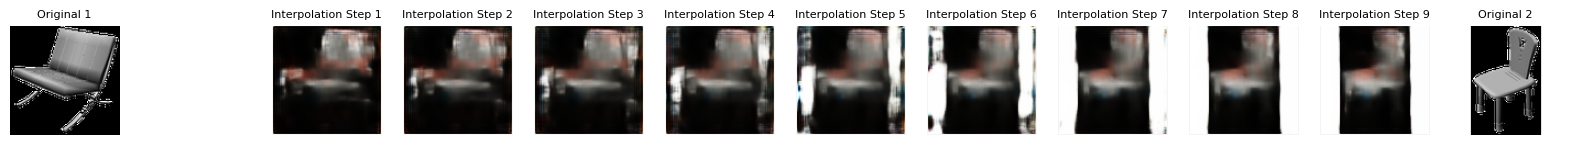

In [56]:
interpolated_encodings = []
for i in range(10):
    alpha = i / 10.0
    interpolated_encoding = alpha * encoding1 + (1 - alpha) * encoding2
    interpolated_encodings.append(interpolated_encoding)

# Decode the interpolated encodings
reconstructed_images = []
for interpolated_encoding in interpolated_encodings:
    interpolated_encoding_reshaped = interpolated_encoding.reshape((1, 100))  # Reshape to (1, 100)
    reconstructed_image = decoder_vae.predict(interpolated_encoding_reshaped)
    reconstructed_images.append(reconstructed_image.squeeze())

# Plot the original images and their corresponding reconstructions interleaved
plt.figure(figsize=(20, 10))

plt.subplot(1, 12, 1)
plt.imshow(img2,cmap='gray')
plt.title('Original 1',fontsize=8)
plt.axis('off')

for i, reconstructed_image in enumerate(reconstructed_images):
    plt.subplot(1, 12, i + 3)
    plt.imshow(reconstructed_image.squeeze(),cmap='gray')
    plt.title(f'Interpolation Step {i + 1}',fontsize=8)
    plt.axis('off')
    
plt.subplot(1, 12, 12)
plt.imshow(img1,cmap='gray')
plt.title('Original 2',fontsize=8)
plt.axis('off')

plt.show()


## UMAP